In [4]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

from importlib import import_module
from sklearn.model_selection import KFold
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import jaccard_score

# special imports
from datasets_utils.datasets import ABUS_dataset, ABUS_test
sys.path.append(str(repo_path / 'SAMed')) if str(repo_path / 'SAMed') not in sys.path else None
from SAMed.segment_anything import sam_model_registry

# Inference of SAMed

## Setup

In [2]:
# HP
run_name = 'vanilla_1class'
fold_num = 0

# run path
weights_path = repo_path / f'experiments/SAMed_ABUS/results/{run_name}/fold{fold_num}/weights'
dirs = os.listdir(weights_path)

Model

In [3]:
# get SAM model
checkpoint_dir = repo_path / 'checkpoints'
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=8,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)
# load weighs
load_path = repo_path / 'experiments/SAMed_ABUS/results/pretrained_weights/fold0/weights/epoch_25.pth'
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device);

Data

In [4]:
# create fold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (_, val_ids) in enumerate(kf.split(range(100))):
    break
print(f'The number of patients in the validation set is {len(val_ids)}')
print(f'The patient ids in the validation set are {val_ids}')
# transform
val_transform = Compose(
        [
            EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

            ScaleIntensityd(keys=["image"]),

            Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
            EnsureTyped(keys=["image"])
        ])

The number of patients in the validation set is 20
The patient ids in the validation set are [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]


In [5]:
# HP
batch_size = 16
multimask_output = True

pat_num = -1
pat_id = [val_ids[pat_num]]

# get data
root_path = repo_path / 'data/challange_2023/with_lesion'
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
# create final paths
image_files = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files] # this is what we will pass to the dataset <-

# define dataset and dataloader
db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(f'The number of slices is {len(db_val)}')

The number of slices is 24


## Evaluate

Jaccard score for slice 0 is 0.5276967930029155
Jaccard score for slice 1 is 0.4812703583061889


Jaccard score for patient [95] is 0.5144843568945539


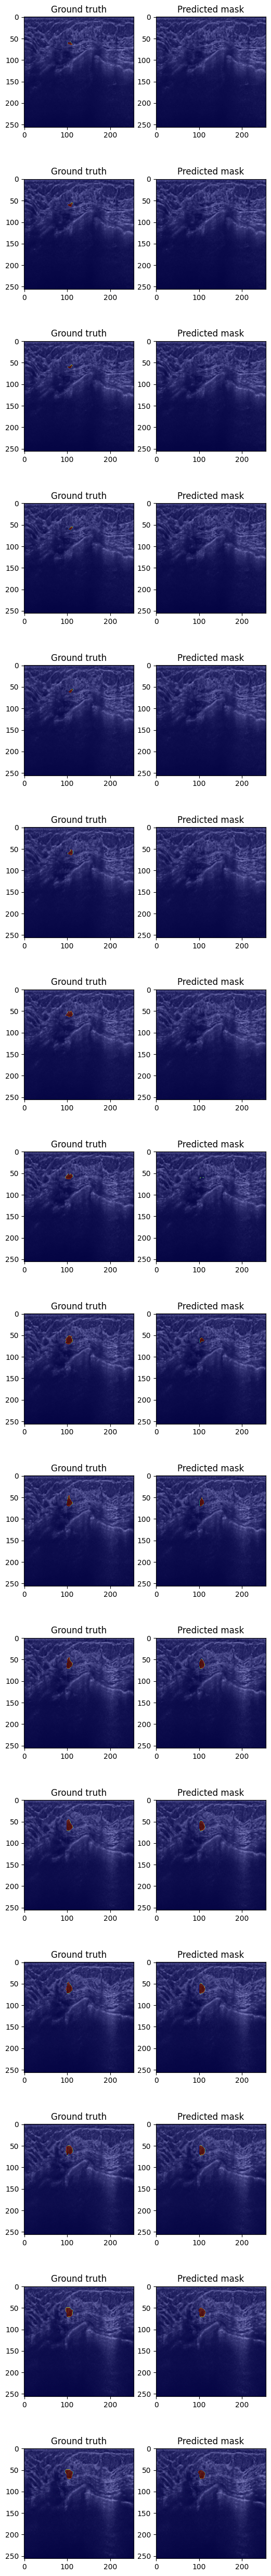

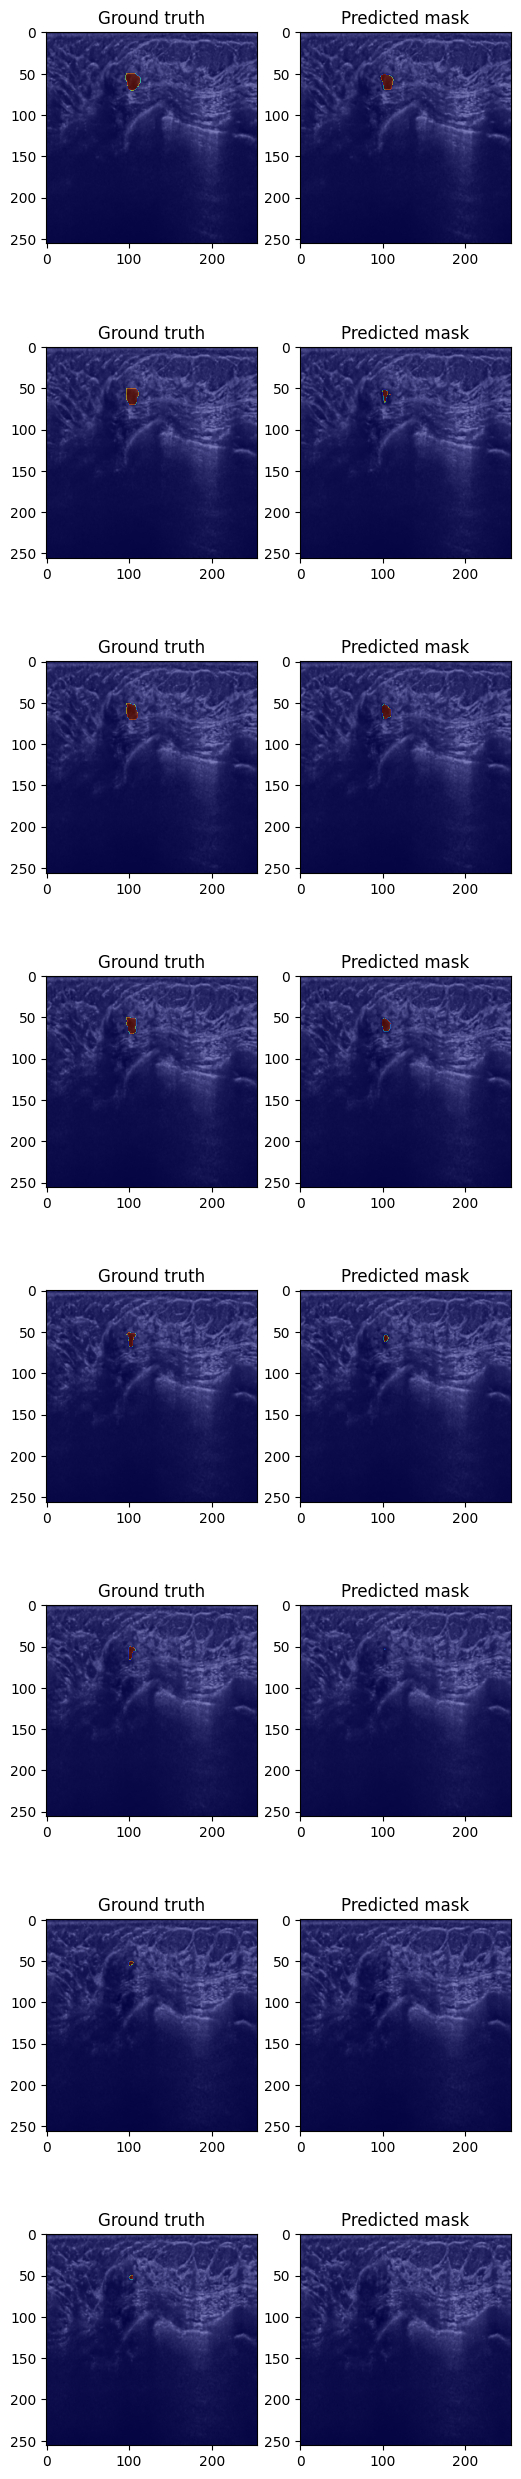

In [6]:
labels_array = []
preds_array = []
for batch_num, sample_batch in enumerate(valloader):
    # get data
    image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
    # forward and losses computing
    outputs = model(image_batch, multimask_output, 256)
    output_masks = outputs['masks'].detach().cpu()
    output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=False)

    #label_batch and output_masks in array
    image_batch = image_batch[:,0].cpu().numpy()
    label_batch = label_batch.cpu().numpy()
    output_masks = output_masks.cpu().numpy()
    # append to list
    labels_array.append(label_batch)
    preds_array.append(output_masks)
    # slide jaccard score
    jaccard_value = jaccard_score(label_batch.flatten(), output_masks.flatten())
    
    print(f'Jaccard score for slice {batch_num} is {jaccard_value}')
    # show image, label and predicted mask
    # change fig size depending on the number of images
    fig, axs = plt.subplots(len(image_batch), 2, figsize=(6, 4*len(image_batch)))
    for i in range(len(image_batch)):
        axs[i, 0].imshow(image_batch[i], cmap='gray')
        axs[i, 0].imshow(label_batch[i], cmap='jet', alpha=0.5)
        axs[i, 0].set_title('Ground truth')
        axs[i, 1].imshow(image_batch[i], cmap='gray')
        axs[i, 1].imshow(output_masks[i], cmap='jet', alpha=0.5)
        axs[i, 1].set_title('Predicted mask')
# get 3D jaccard score
labels_array = np.concatenate(labels_array)
preds_array = np.concatenate(preds_array)
jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
print(f'Jaccard score for patient {pat_id} is {jaccard_value}')

In [7]:
# analyze output
pure_output = outputs['low_res_logits'].detach().cpu()
pure_mask = outputs['masks'].detach().cpu()

In [8]:
pure_mask.shape

torch.Size([8, 9, 256, 256])

Low resolution logits shape: torch.Size([8, 9, 64, 64])
Masks shape: torch.Size([8, 9, 256, 256])


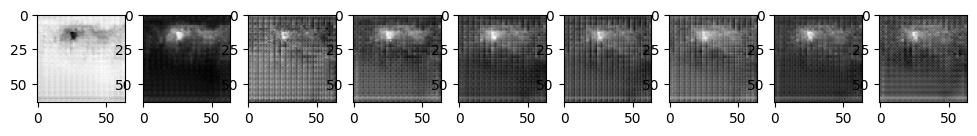

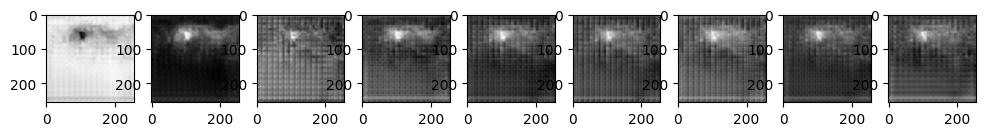

In [9]:
print(f'Low resolution logits shape: {pure_output.shape}')
fig, axs = plt.subplots(1, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[i].imshow(pure_output[0, i, :, :].numpy(), cmap='gray')
print(f'Masks shape: {pure_mask.shape}')
fig, axs = plt.subplots(1, pure_mask.shape[1], figsize=(12, 5))
for i in range(pure_mask.shape[1]):
    axs[i].imshow(pure_mask[0, i, :, :].numpy(), cmap='gray')

logits after softmax shape: torch.Size([1, 9, 64, 64])


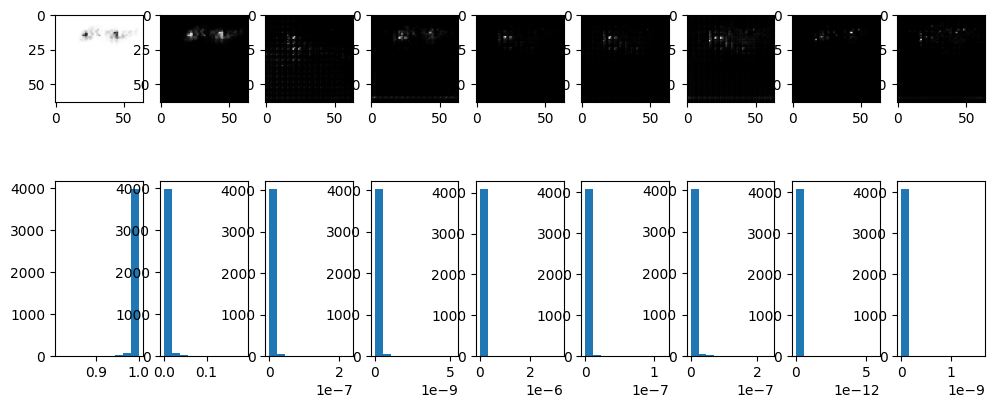

In [10]:
inputs = torch.softmax(pure_output, dim=1)
print(f'logits after softmax shape: {inputs.shape}')
fig, axs = plt.subplots(2, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[0,i].imshow(inputs[0, i, :, :].numpy(), cmap='gray')
    # histogram per image
    axs[1,i].hist(inputs[0, i, :, :].numpy().flatten())

## Full evaluation

In [47]:
# HP
batch_size = 32
multimask_output = True

patients_jaccard = np.zeros((len(val_ids), 2))
patients_dice = np.zeros((len(val_ids), 2))
for pat_num in range(len(val_ids)):
    pat_id = [val_ids[pat_num]]

    # get data
    root_path = repo_path / 'data/challange_2023/with_lesion'
    path_images = (root_path / "image_mha")
    path_labels = (root_path / "label_mha")
    # get all files in the folder in a list, only mha files
    image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
    # now, we will check if the path has at least one of the ids in the train_ids list
    val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
    # create final paths
    image_files = np.array([path_images / i for i in val_files])
    label_files = np.array([path_labels / i for i in val_files])
    list_val = [image_files, label_files] # this is what we will pass to the dataset <-

    # define dataset and dataloader
    db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
    valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    print(f'\nThe number of slices is {len(db_val)}')

    labels_array = []
    preds_array = []
    for batch_num, sample_batch in enumerate(valloader):
        # get data
        image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
        # forward and losses computing
        outputs = model(image_batch, multimask_output, 256)
        output_masks = outputs['masks'].detach().cpu()
        output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=False)

        #label_batch and output_masks in array
        image_batch = image_batch[:,0].cpu().numpy()
        label_batch = label_batch.cpu().numpy()
        output_masks = output_masks.cpu().numpy()
        # append to list
        labels_array.append(label_batch)
        preds_array.append(output_masks)
        
    # get 3D jaccard score
    labels_array = np.concatenate(labels_array)
    preds_array = np.concatenate(preds_array)
    jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
    # dice from jaccard
    dice_value = 2*jaccard_value/(1+jaccard_value)
    print(f'Jaccard score for patient {pat_id} is {jaccard_value}')
    print(f'Dice score for patient {pat_id} is {dice_value}')
    # store in array
    patients_jaccard[pat_num, 0] = pat_id[0]
    patients_jaccard[pat_num, 1] = jaccard_value
    patients_dice[pat_num, 0] = pat_id[0]
    patients_dice[pat_num, 1] = dice_value
print(f'\nMean dice score: {np.mean(patients_dice[:, 1])}')


The number of slices is 48
Jaccard score for patient [2] is 0.6947481352814958
Dice score for patient [2] is 0.8198836403098905

The number of slices is 14
Jaccard score for patient [7] is 0.5524455483377914
Dice score for patient [7] is 0.7117100486123932

The number of slices is 33
Jaccard score for patient [8] is 0.5020432969381982
Dice score for patient [8] is 0.6684804598663374

The number of slices is 14
Jaccard score for patient [13] is 0.46408104789193616
Dice score for patient [13] is 0.6339554064443979

The number of slices is 39
Jaccard score for patient [16] is 0.24388489208633093
Dice score for patient [16] is 0.3921341816078658

The number of slices is 55
Jaccard score for patient [22] is 0.594341610233258
Dice score for patient [22] is 0.745563694027033

The number of slices is 22
Jaccard score for patient [24] is 0.6506140917905624
Dice score for patient [24] is 0.7883297434893285

The number of slices is 35
Jaccard score for patient [26] is 0.5110022763330344
Dice sco

# Inference validation set

In [31]:
import re
# Define a custom sorting key function
def slice_number(filename):
    match = re.search(r'slice_(\d+)\.mha', filename)
    if match:
        return int(match.group(1))
    return -1  # Default value if the pattern is not found

In [3]:
# HP
batch_size = 8
num_classes = 1

# get SAM model
checkpoint_dir = repo_path / 'checkpoints'
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=num_classes,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)

# fold model lists
optimum_weights = [
        'experiments/SAMed_ABUS/results/scratch_c1_val-all/fold0/weights/epoch_19.pth',
        'experiments/SAMed_ABUS/results/scratch_c1_val-all/fold1/weights/epoch_9.pth',
        'experiments/SAMed_ABUS/results/scratch_c1_val-all/fold2/weights/epoch_3.pth',
        'experiments/SAMed_ABUS/results/scratch_c1_val-all/fold3/weights/epoch_41.pth',
        'experiments/SAMed_ABUS/results/scratch_c1_val-all/fold4/weights/epoch_3.pth'
    ]

val_transform = Compose(
        [
            ScaleIntensityd(keys=["image"]),
            Resized(keys=["image"], spatial_size=(256, 256),mode=['area']),
            EnsureTyped(keys=["image"])
        ])

In [34]:
pat_id = 100 # e.g. patient
    
# get data
root_path = repo_path / 'data/challange_2023/Val/all-slices'
path_images = (root_path / "image_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
val_files = [file for file in image_files if f'id_{pat_id}_' in file]
val_files = sorted(val_files, key=slice_number)

# create final paths
image_files = np.array([path_images / i for i in val_files])
print(image_files)
# define dataset and dataloader
db_val = ABUS_test(transform=val_transform,list_dir=image_files)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(f'The patient id is {pat_id}')
print(f'The number of slices is {len(db_val)}')

[PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_0.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_1.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_2.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_3.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_4.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_5.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_6.mha')
 PosixPath('/home/ricardo/ABUS2023_documents/tdsc_abus23/data/challange_2023/Val/all-slices/image_mha/id_100_slice_7.mha')
 PosixPath('/hom

In [ ]:
# store final mask per patient
output_mask_final = torch.zeros((len(db_val), num_classes+1,256,256))

# LOOP
model_path = optimum_weights[0] # for each model learned
# load weighs
load_path = repo_path / model_path
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device)

# to append masks
model_mask = []
for sample_batch in valloader: # get some slides
    # get data
    image_batch = sample_batch["image"].to(device)
    # forward and losses computing
    outputs = model(image_batch, True, 256)
    # stack the masks
    model_mask.append(outputs['masks'].detach().cpu())